In [1]:
from itertools import repeat
import numpy as np 
import pandas as pd 
import yfinance as yf 
import talib
import matplotlib.pyplot as plt 
plt.style.use('seaborn-whitegrid')
from p_tqdm import p_umap
from backtesting import Strategy, Backtest
from backtesting.lib import crossover

/home/kfuangsung/anaconda3/envs/pyenv/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
df = yf.download(tickers='KBANK.BK', period='10y', interval='1d', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.Close

Date
2012-09-26    144.924835
2012-09-27    143.332260
2012-09-28    145.323029
2012-10-01    146.915558
2012-10-02    147.313705
                 ...    
2022-09-20    150.500000
2022-09-21    150.000000
2022-09-22    151.000000
2022-09-23    151.500000
2022-09-26    149.500000
Name: Close, Length: 2435, dtype: float64

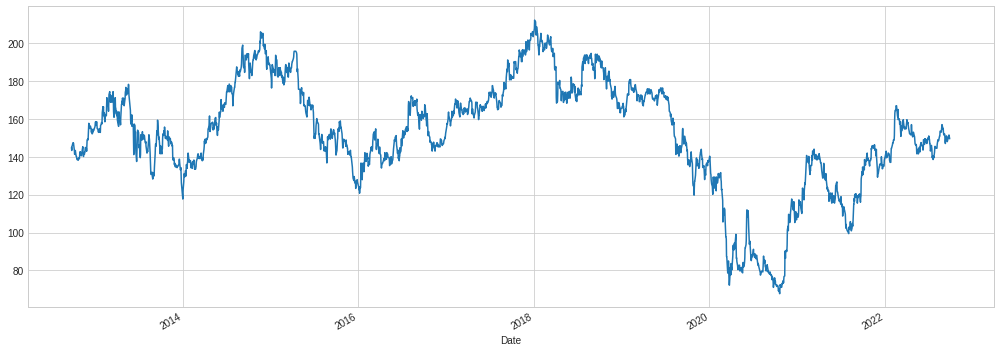

In [4]:
df.Close.plot(figsize=(14,5))
plt.tight_layout()
plt.show()

In [5]:
class DemaTemaCrossover(Strategy):
    n = 10
    
    def init(self):
        self.dema = self.I(talib.DEMA, self.data.Close, self.n)
        self.tema = self.I(talib.TEMA, self.data.Close, self.n)
        
    def next(self):
        if crossover(self.tema, self.dema):
            if not self.position:
                self.buy()
            else:
                return
            
        elif crossover(self.dema, self.tema):
            if self.position:
                self.position.close()
            else:
                return

In [6]:
bt = Backtest(df, DemaTemaCrossover, cash=10_000, exclusive_orders=True, commission=0.002)

## optimize | maximize 'Equity Final'

In [7]:
stats = bt.optimize(n=range(2, 101, 1),
                    maximize='Equity Final [$]')

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
stats 

Start                     2012-09-26 00:00:00
End                       2022-09-26 00:00:00
Duration                   3652 days 00:00:00
Exposure Time [%]                   49.650924
Equity Final [$]                 18017.419692
Equity Peak [$]                  19544.460514
Return [%]                          80.174197
Buy & Hold Return [%]                3.156923
Return (Ann.) [%]                    6.282515
Volatility (Ann.) [%]               21.877886
Sharpe Ratio                         0.287163
Sortino Ratio                        0.489699
Calmar Ratio                         0.165971
Max. Drawdown [%]                  -37.853064
Avg. Drawdown [%]                   -5.696866
Max. Drawdown Duration      885 days 00:00:00
Avg. Drawdown Duration      103 days 00:00:00
# Trades                                   22
Win Rate [%]                        40.909091
Best Trade [%]                      88.654938
Worst Trade [%]                    -16.951807
Avg. Trade [%]                    

In [9]:
stats._strategy

<Strategy DemaTemaCrossover(n=50)>

In [10]:
bt.plot(plot_drawdown=True)

Row(id='1482', ...)

## optimize | maximize 'Sortino Ratio'

In [11]:
stats = bt.optimize(n=range(2, 101, 1),
                    maximize='Sortino Ratio')

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

In [12]:
stats

Start                     2012-09-26 00:00:00
End                       2022-09-26 00:00:00
Duration                   3652 days 00:00:00
Exposure Time [%]                   49.650924
Equity Final [$]                 18017.419692
Equity Peak [$]                  19544.460514
Return [%]                          80.174197
Buy & Hold Return [%]                3.156923
Return (Ann.) [%]                    6.282515
Volatility (Ann.) [%]               21.877886
Sharpe Ratio                         0.287163
Sortino Ratio                        0.489699
Calmar Ratio                         0.165971
Max. Drawdown [%]                  -37.853064
Avg. Drawdown [%]                   -5.696866
Max. Drawdown Duration      885 days 00:00:00
Avg. Drawdown Duration      103 days 00:00:00
# Trades                                   22
Win Rate [%]                        40.909091
Best Trade [%]                      88.654938
Worst Trade [%]                    -16.951807
Avg. Trade [%]                    

In [13]:
stats._strategy

<Strategy DemaTemaCrossover(n=50)>

In [14]:
bt.plot(plot_drawdown=True)

Row(id='2294', ...)

## plot parameters

In [15]:
def get_strat_returns(data, n, cash, commission):
    bt = Backtest(df, DemaTemaCrossover, cash=cash, exclusive_orders=True, commission=commission)
    stats = bt.run(n=n)
    results = [n]
    s = stats[['Exposure Time [%]', 'Return [%]', 'Return (Ann.) [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 
               'Max. Drawdown [%]', 'Avg. Drawdown [%]', 'Win Rate [%]', 'Avg. Trade [%]', '# Trades', 'Profit Factor']]
    results += s.to_list()
    return results

In [16]:
res = p_umap(get_strat_returns, repeat(df.copy(deep=True)), 
             range(2, 101, 1), repeat(10_000), repeat(0.002))

  0%|          | 0/99 [00:00<?, ?it/s]

In [17]:
res_df = pd.DataFrame(res, columns=['n', 'exposure', 'rets', 'ann_rets', 'sharpe', 'sortino', 
                                    'calmar', 'maxdd', 'avgdd', 'win_rate', 'avg_trade', 
                                    'n_trades', 'profit_factor'])

In [18]:
res_df

,n,exposure,rets,ann_rets,sharpe,sortino,calmar,maxdd,avgdd,win_rate,avg_trade,n_trades,profit_factor
0,3,65.133470,-60.998012,-9.284551,0.000000,0.000000,0.000000,-69.674906,-10.024655,34.974093,-0.247634,386,0.839468
1,4,62.422998,-60.287031,-9.114792,0.000000,0.000000,0.000000,-66.882817,-10.163064,36.092715,-0.309289,302,0.829952
2,5,60.616016,-56.323978,-8.215683,0.000000,0.000000,0.000000,-68.680411,-8.462742,34.400000,-0.332048,250,0.851840
3,7,56.344969,-51.381578,-7.191707,0.000000,0.000000,0.000000,-75.652139,-11.705027,30.000000,-0.403565,180,0.851127
4,2,71.540041,-69.300191,-11.504073,0.000000,0.000000,0.000000,-77.067028,-8.180476,37.981651,-0.219815,545,0.830106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,96,48.459959,16.811172,1.621128,0.082464,0.127361,0.026071,-62.182019,-7.387482,53.846154,1.198301,13,1.510637
95,97,48.336756,15.055662,1.461999,0.074847,0.115401,0.023734,-61.599788,-8.361242,58.333333,1.177972,12,1.488224
96,98,48.254620,16.411878,1.585123,0.081426,0.126114,0.025631,-61.844502,-7.444619,50.000000,1.265612,12,1.542218
97,99,48.008214,26.598002,2.470825,0.128060,0.203183,0.042769,-57.772013,-8.018293,50.000000,1.981019,12,1.852074


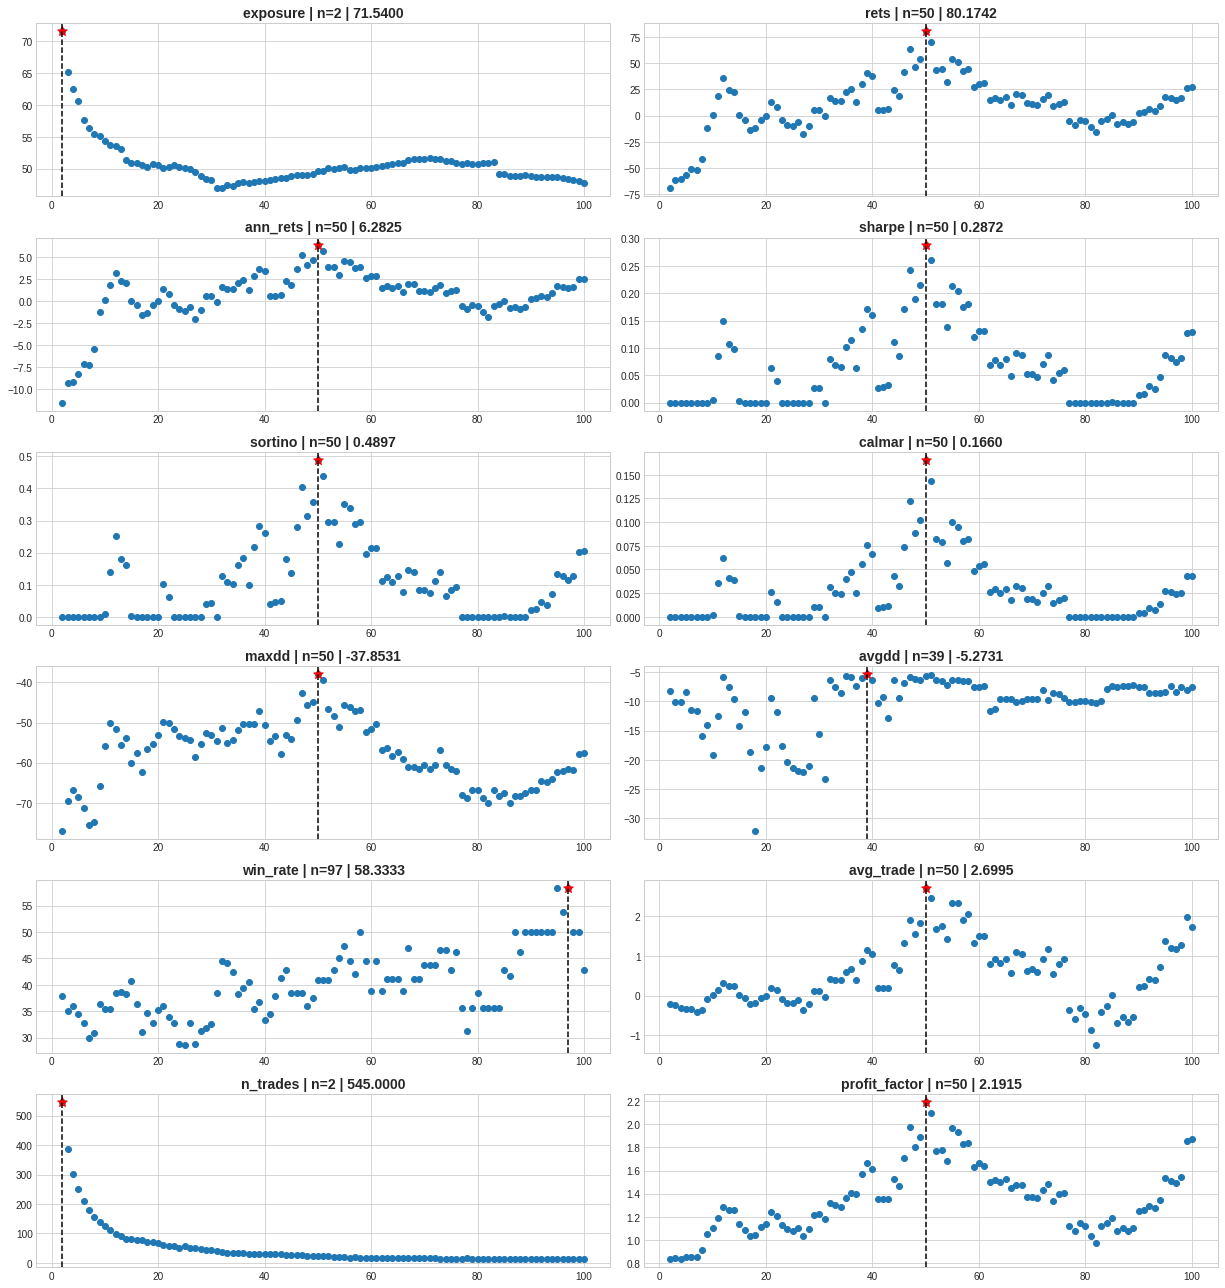

In [19]:
plot_coord = []
for r in range(6):
    for c in range(2):
        plot_coord.append((r,c))

fig, ax = plt.subplots(6, 2, figsize=(17, 18))
for i, col in enumerate(res_df.columns[1:]):
    d_ = res_df[['n', col]].dropna(axis=0)
    ax[plot_coord[i]].scatter(d_.n.values, d_[col].values)
    sorted_d_ = d_.sort_values(by=col, ascending=False)
    best_n = sorted_d_.n.values[0]
    best_v = sorted_d_[col].values[0]
    ax[plot_coord[i]].axvline(x=best_n, color='k', linestyle='--')
    ax[plot_coord[i]].scatter(best_n, best_v, color='r', marker='*', s=100)
    ax[plot_coord[i]].set_title(f"{col} | n={best_n} | {best_v:.4f}", fontdict={'size':14, 'weight':'bold'})
    
plt.tight_layout()
plt.show()